# fix-restarts

Fix restart files that have had the landmask enlarged. 
**Does not fix points where land had been changed to ocean.**

Use this in conjunction with bathymetry-closeup-baffin.ipynb

See https://github.com/OceansAus/access-om2/issues/99#issuecomment-396773493 and http://cosima.org.au/index.php/2018/06/12/technical-working-group-meeting-june-2018/


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import netCDF4 as nc
import IPython.display

In [2]:
# file = '/g/data3/hh5/tmp/cosima/bathymetry/topog_latest.nc'

# see https://github.com/OceansAus/access-om2/issues/99
badbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_10_17_yenesei.nc'
fixedbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_06_2018.baffin.nc'

baddepth = nc.Dataset(badbathyfile).variables['depth'][:,:]
depth = nc.Dataset(fixedbathyfile).variables['depth'][:,:]

# file2 = '/g/data3/hh5/tmp/cosima/bathymetry/ocean_hgrid.nc'
# data2 = nc.Dataset(file2)
# lons = data2.variables['x'][::2,::2]
# lats = data2.variables['y'][::2,::2]


In [41]:
# from ocean_model_nml in ocean/input.nml
io_layout = (5, 5)

gridshape = np.shape(depth)  # NB: (y, x) order
tilex = int(np.round(gridshape[1]/io_layout[0]))  # tile x size
tiley = int(np.round(gridshape[0]/io_layout[1]))  # tile y size

In [42]:
maskdiff = np.ma.getmask(depth).astype(int)-np.ma.getmask(baddepth).astype(int)
maskdiff[maskdiff<0] = 0  # don't consider reductions in land mask
jj,ii = np.nonzero(maskdiff)  # arrays of j, i coords where land mask has increased

xbox = (ii/tilex).astype(int)
ybox = (jj/tiley).astype(int)
tilenums = set(xbox+io_layout[0]*ybox)  # tiles with landmask increases
tilenums

{17, 22}

In [66]:
ii

array([2121, 2154, 2155, 2156, 2154, 2155, 2156, 2157, 2158, 2154, 2155,
       2156, 2157, 2158, 2153, 2154, 2155, 2156, 2157, 2158, 2153, 2154,
       2155, 2156, 2157, 2158, 2153, 2154, 2155, 2156, 2150, 2151, 2152,
       2153, 2154, 2155, 2156, 2150, 2151, 2152, 2153, 2154, 2155, 2156,
       2150, 2151, 2152, 2154, 2155, 2156, 2151, 2152, 2153, 2154, 2155,
       2156, 2152, 2153, 2154, 2155, 2156, 2150, 2151, 2154, 2155, 2156,
       2149, 2150, 2151, 2152, 2153, 2154, 2149, 2150, 2151, 2152, 2153,
       2154, 2148, 2149, 2150, 2151, 2148, 2149, 2151, 2152, 2153, 2148,
       2149, 2151, 2152, 2153, 2146, 2147, 2148, 2151, 2152, 2153, 2146,
       2147, 2148, 2151, 2152, 2148, 2149, 2152, 2148, 2149, 1558])

In [67]:
jj

array([2072, 2073, 2073, 2073, 2074, 2074, 2074, 2074, 2074, 2075, 2075,
       2075, 2075, 2075, 2076, 2076, 2076, 2076, 2076, 2076, 2077, 2077,
       2077, 2077, 2077, 2077, 2078, 2078, 2078, 2078, 2079, 2079, 2079,
       2079, 2079, 2079, 2079, 2080, 2080, 2080, 2080, 2080, 2080, 2080,
       2081, 2081, 2081, 2081, 2081, 2081, 2082, 2082, 2082, 2082, 2082,
       2082, 2083, 2083, 2083, 2083, 2083, 2084, 2084, 2084, 2084, 2084,
       2085, 2085, 2085, 2085, 2085, 2085, 2086, 2086, 2086, 2086, 2086,
       2086, 2087, 2087, 2087, 2087, 2088, 2088, 2088, 2088, 2088, 2089,
       2089, 2089, 2089, 2089, 2090, 2090, 2090, 2090, 2090, 2090, 2091,
       2091, 2091, 2091, 2091, 2092, 2092, 2092, 2093, 2093, 2609])

(540, 720)
Fixing ocean_barotropic.res.nc.0017 eta_t
(1, 540, 720)
Fixing ocean_barotropic.res.nc.0017 eta_t_bar
(1, 540, 720)
(540, 720)
Fixing ocean_barotropic.res.nc.0022 eta_t
(1, 540, 720)
Fixing ocean_barotropic.res.nc.0022 eta_t_bar
(1, 540, 720)


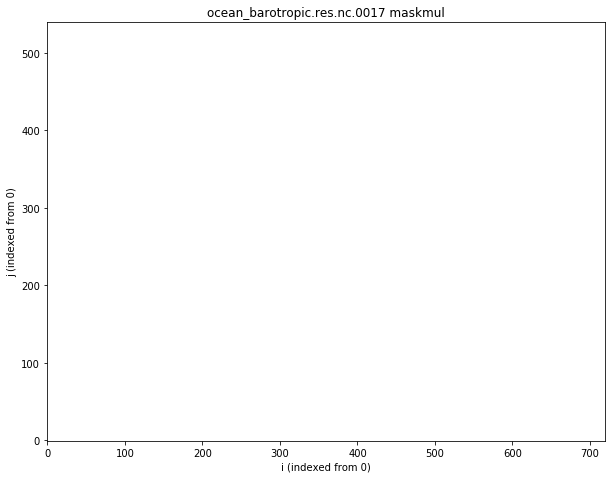

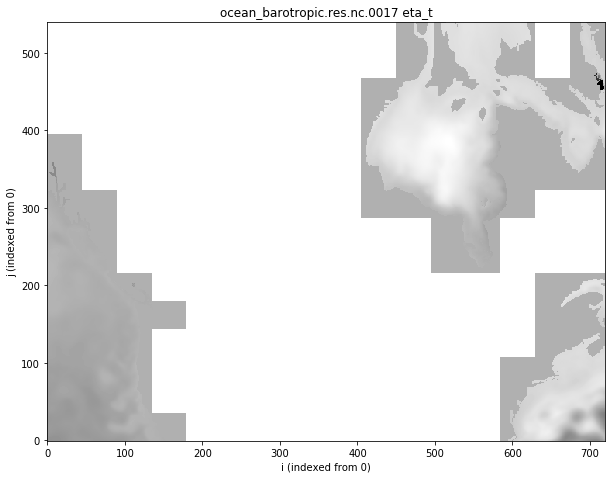

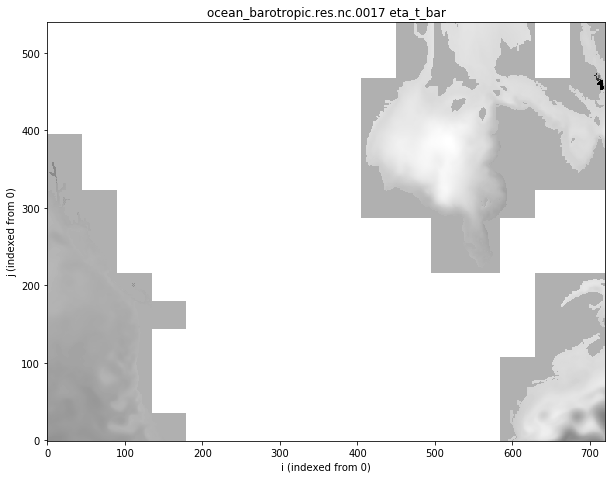

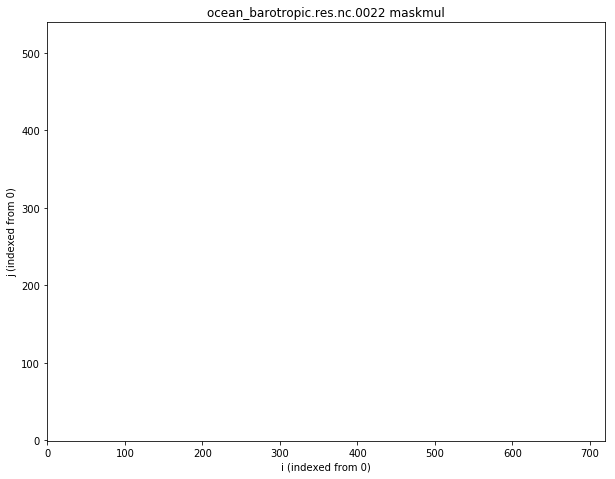

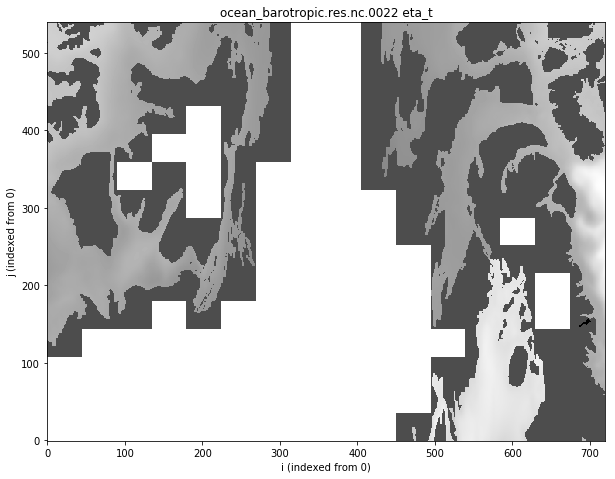

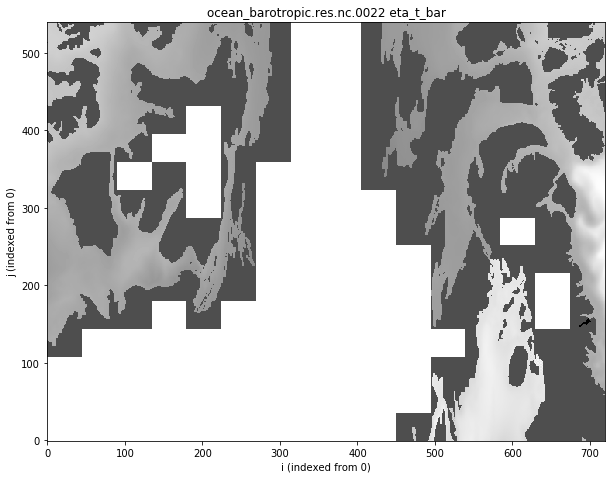

In [68]:
restartbase = 'ocean_barotropic.res.nc.'
varnames = ['eta_t', 'eta_t_bar']
for jtile in range(io_layout[1]):
    for itile in range(io_layout[0]):
        tilenum = itile+io_layout[0]*jtile
#         print(itile, jtile, tilenum)
        if tilenum in tilenums:
            restartin = restartbase+str(tilenum).zfill(4)
            restartout = restartin+'-fixed'
            maskmul = 1.0-maskdiff[jtile:jtile+tiley,itile:itile+tilex]
            print(np.shape(maskmul))
            plt.figure(figsize=(10,10))
            plt.imshow(maskmul, origin='lower', cmap=cm.binary)
            plt.title(restartin+' maskmul')
            plt.xlabel('i (indexed from 0)')
            plt.ylabel('j (indexed from 0)');
            for v in varnames:
                print('Fixing '+restartin+' '+v)
                field = nc.Dataset(restartin).variables[v][:,:]
                print(np.shape(field))
                plt.figure(figsize=(10,10))
                plt.imshow(field[0,:,:], origin='lower', cmap=cm.binary)
                plt.title(restartin+' '+v)
                plt.xlabel('i (indexed from 0)')
                plt.ylabel('j (indexed from 0)');


# TODO: extract subset of maskdiff to match this tile, multiply tile by (1-subset) and write to output
# BE CAREFUL TO ALIGN THEM PROPERLY!!!

In [50]:
    
for tilenum in tilenums:
    restartin = restartbase+str(tilenum).zfill(4)
    restartout = restartin+'-fixed'
    maskmul = 1.0-maskdiff[]
    for v in varnames:
        print('Fixing '+restartin+' '+v)
        field = nc.Dataset(restartin).variables[v][:,:]
        
        print(field)
# TODO: extract subset of maskdiff to match this tile, multiply tile by (1-subset) and write to output
# BE CAREFUL TO ALIGN THEM PROPERLY!!!

Fixing ocean_barotropic.res.nc.0017 eta_t
[[[0.389521461349511 0.389742251442331 0.389405478857081 ...,
   0.21854799822964552 0.16954227012055448 0.11704661013158839]
  [0.3867340222064159 0.38795445677794044 0.3886365084968595 ...,
   0.169988070369694 0.11674408570974715 0.0610914108600304]
  [0.38082149769507295 0.3827245131272874 0.3844931160932859 ...,
   0.11533355565137127 0.06090659085471267 0.0028653763120926154]
  ..., 
  [-- -- -- ..., 0.0 0.0 0.0]
  [-- -- -- ..., 0.0 0.0 0.0]
  [-- -- -- ..., 0.0 0.0 0.0]]]
Fixing ocean_barotropic.res.nc.0017 eta_t_bar
[[[0.39799267668463667 0.39762809398014765 0.39634070750578154 ...,
   0.2070067478039047 0.1671123697625968 0.11635926602817889]
  [0.39554913835639877 0.39620795971066597 0.3960052189439814 ...,
   0.16787897311958022 0.1196211771341814 0.068499451789096]
  [0.3892239565765561 0.39056645652747574 0.3919037208489492 ...,
   0.11994084997549836 0.07294814663153987 0.007025090724068848]
  ..., 
  [-- -- -- ..., 0.0 0.0 0.0]


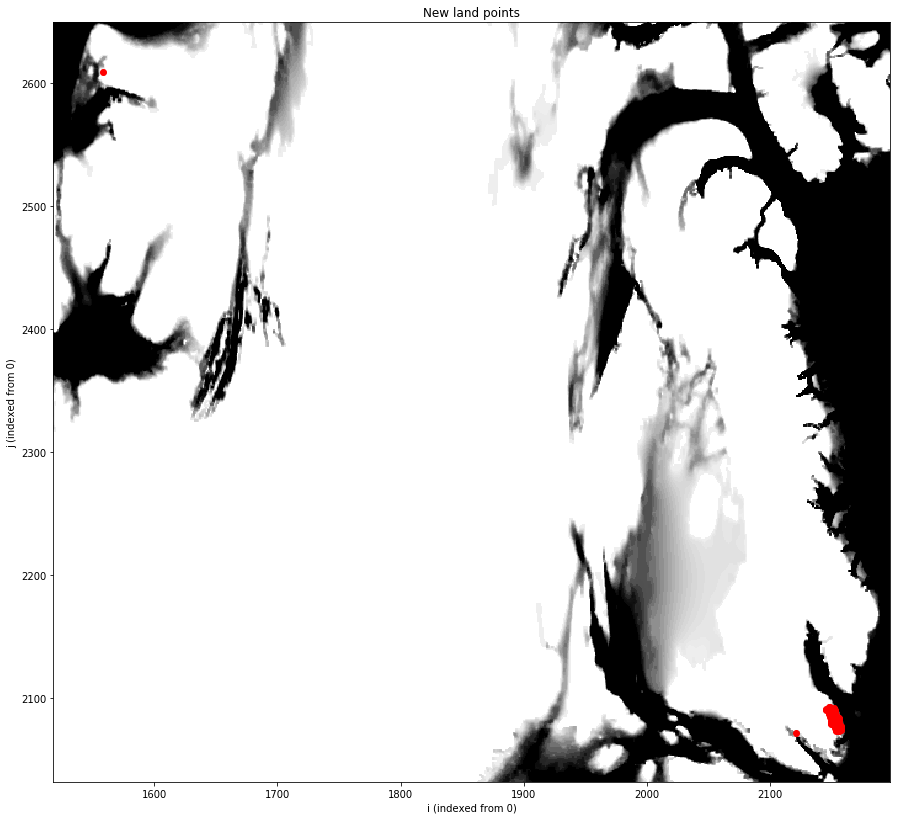

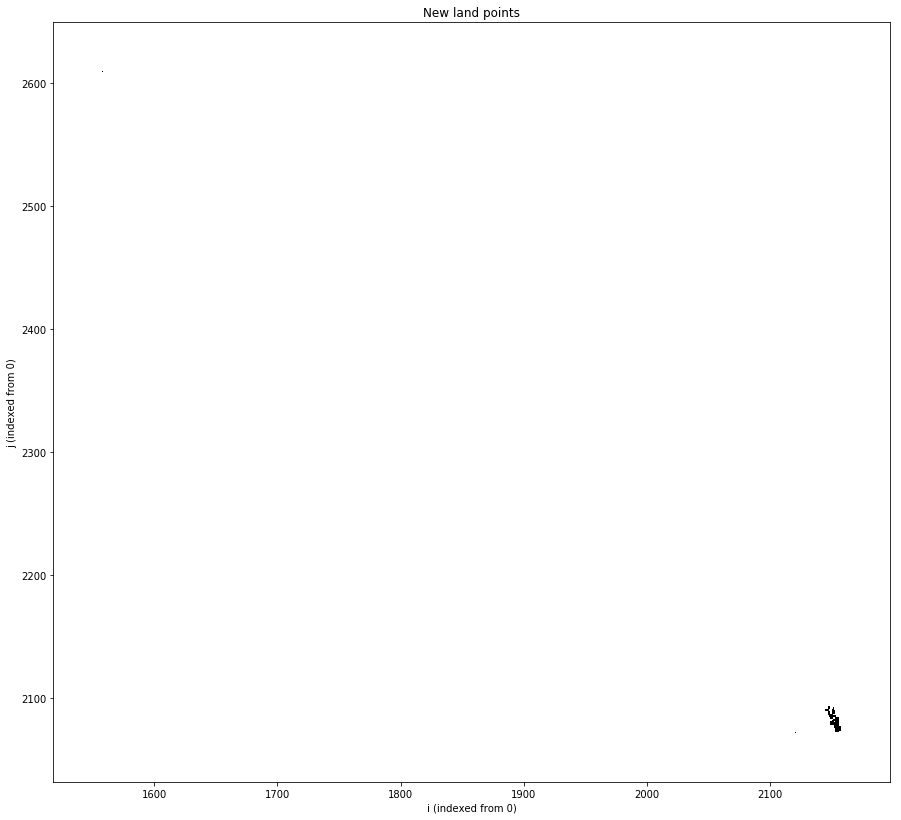

In [98]:
# plt.figure(figsize=(15,15))
# plt.imshow(maskdiff, origin='lower')
# plt.colorbar()
# # plt.scatter(jj,ii, facecolors='none', edgecolors='w')
# plt.title('New land points')
# plt.xlabel('i (indexed from 0)')
# plt.ylabel('j (indexed from 0)');

plt.figure(figsize=(15,15))
plt.imshow(depth, vmin=0, vmax=150, origin='lower', cmap=cm.binary)
plt.scatter(ii,jj, facecolors='r', edgecolors='r')
plt.xlim(min(ii)-margin,max(ii)+margin)
plt.ylim(min(jj)-margin,max(jj)+margin)
plt.title('New land points')
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');

plt.figure(figsize=(15,15))
plt.imshow(maskdiff, origin='lower', cmap=cm.binary)
plt.xlim(min(ii)-margin,max(ii)+margin)
plt.ylim(min(jj)-margin,max(jj)+margin)
plt.title('New land points')
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');

In [56]:
np.ma.min(maskdiff)

0

In [57]:
np.count_nonzero(maskdiff)

109

In [71]:
np.count_nonzero(maskdiff[j-margin:j+margin,i-margin:i+margin])

108